In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1,(n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)

    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []

    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)

        if(0.1*i == 0.5):
            continue

        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21,1)

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def ReLU(x):
    return np.where(x > 0, x, 0)

def derivative_ReLU(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1-np.multiply(x, x)


def show_result(x, y, pred_y):
    plt.subplot(2,2,3)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.subplot(2,2,4)
    plt.text(0, 0, f'Accuracy: {sum(pred_y == y)/y.size}', fontsize = 16,
         bbox = dict(facecolor = 'white', alpha = 0.5))
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')


    plt.show()

def MSELoss(y_hat, y, calculate_Grad = True):
    distance = np.sum((y_hat-y)**2)
    if calculate_Grad:
        return distance/y_hat.shape[0], 2*(y_hat - y)/y_hat.shape[0]
    return distance/y_hat.shape[0]

#Fully Connected Layers
class Layer:
    def __init__(self, input_size, output_size, activate = "Sigmoid"):
        self.input_size = input_size
        self.output_size = output_size
        self.activate = activate
        self.v_w = 0
        self.v_b = 0
        self.total_w = 0
        self.total_b = 0
        #initialize weight and bias
        self.w = np.random.randn(input_size, output_size) #shape(2,n)
        self.b = np.random.randn(1, output_size)/100 #shape(1,n)
    def forward(self,x):
        self.x = x
        z = np.dot(x,self.w) +self.b
        if self.activate == "Sigmoid":
            z = sigmoid(z)
        elif self.activate == "ReLU":
            z = ReLU(z)
        elif self.activate == "tanh":
            z = tanh(z)
        else:
            pass
        self.z = z

        return z
    def backward(self, upstream_grad, lr=0.01, optim = "momentum", decay = 0.9):
        if self.activate == "Sigmoid":
            grad = upstream_grad * derivative_sigmoid(self.z)
        elif self.activate == "ReLU":
            grad = upstream_grad * derivative_ReLU(self.z)
        elif self.activate == "tanh":
            grad = upstream_grad * derivative_tanh(self.z)
        else:
            grad = upstream_grad

        if optim == "SGD":
            self.b -= np.sum(grad) * lr
            self.w -= np.dot(self.x.T, grad) *lr
        elif optim == "momentum":
            self.v_w = decay * self.v_w + lr * np.dot(self.x.T, grad)
            self.v_b = decay * self.v_b + lr * np.sum(grad)
            self.b -= self.v_b
            self.w -= self.v_w
        elif optim == "AdaGrad":
            self.total_w += np.dot(self.x.T, grad) ** 2
            self.total_b += np.sum(grad) ** 2
            self.b -= np.sum(grad) * lr / (np.sqrt(self.total_b) + 1e-8)
            self.w -= np.dot(self.x.T, grad) * lr / (np.sqrt(self.total_w) + 1e-8)

        return np.dot(grad,self.w.T)


#2 FC layers model
class Model:
    def __init__(self, input_size= 2, hidden_size= 10, output_size= 1, lr=0.01,
                 optim = "SGD", activate = "ReLU", show_epoch = 10000, decay = 0.9):
        self.layer1 = Layer(input_size, hidden_size, activate)
        self.layer2 = Layer(hidden_size, hidden_size, activate)
        if activate == "None":
            self.output = Layer(hidden_size,output_size, activate)
        else:
            self.output = Layer(hidden_size,output_size, "Sigmoid")
        self.lr = lr
        self.loss = []
        self.show_epoch = show_epoch
        self.epoch = 0
        self.optim = optim
        self.decay = decay

    def train(self,x,y,epoch = 100000):
        self.epoch += epoch
        for i in range(epoch):
            output = self.output.forward(self.layer2.forward(self.layer1.forward(x)))
            loss, grad = MSELoss(output, y)
            self.layer1.backward(self.layer2.backward(self.output.backward(grad, self.lr, self.optim, self.decay)
                                , self.lr, self.optim, self.decay), self.lr, self.optim, self.decay)
            self.loss.append(loss)
            if i%self.show_epoch == 0:
                print(f"epoch {i} loss : {loss}")
        self.prediction = output
        plt.subplot(2,1,1)
        plt.title("Learning Curve", fontsize = 18)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(loss)
        return output

    def show_result(self,x,y):
        plt.plot(self.loss)
        print(f"Accuracy : {sum((self.prediction > 0.5)== (y==1))/y.size}")
        print("Prediction : ")
        for i in range(y.size):
            print(f"Iter{i+1} |    Ground truth: {y[i]} |     prediction: {self.prediction[i]} |")
        show_result(x,y,self.prediction>0.5)

epoch 0 loss : 0.2628302901660786
epoch 10000 loss : 0.015063095652393065
epoch 20000 loss : 0.008229608051337748
epoch 30000 loss : 0.0058514940625119406
epoch 40000 loss : 0.004654812328842541
epoch 50000 loss : 0.003928908665779767
epoch 60000 loss : 0.0034358184166474117
epoch 70000 loss : 0.0030745004378831924
epoch 80000 loss : 0.0027948940663429863
epoch 90000 loss : 0.0025693919279855797
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [3.57137962e-05] |
Iter2 |    Ground truth: [0] |     prediction: [6.08074965e-08] |
Iter3 |    Ground truth: [0] |     prediction: [4.13789073e-08] |
Iter4 |    Ground truth: [1] |     prediction: [0.99999955] |
Iter5 |    Ground truth: [1] |     prediction: [0.66280268] |
Iter6 |    Ground truth: [0] |     prediction: [4.3006947e-06] |
Iter7 |    Ground truth: [1] |     prediction: [0.99993138] |
Iter8 |    Ground truth: [1] |     prediction: [0.99999969] |
Iter9 |    Ground truth: [1] |     prediction: [0.99999832] 

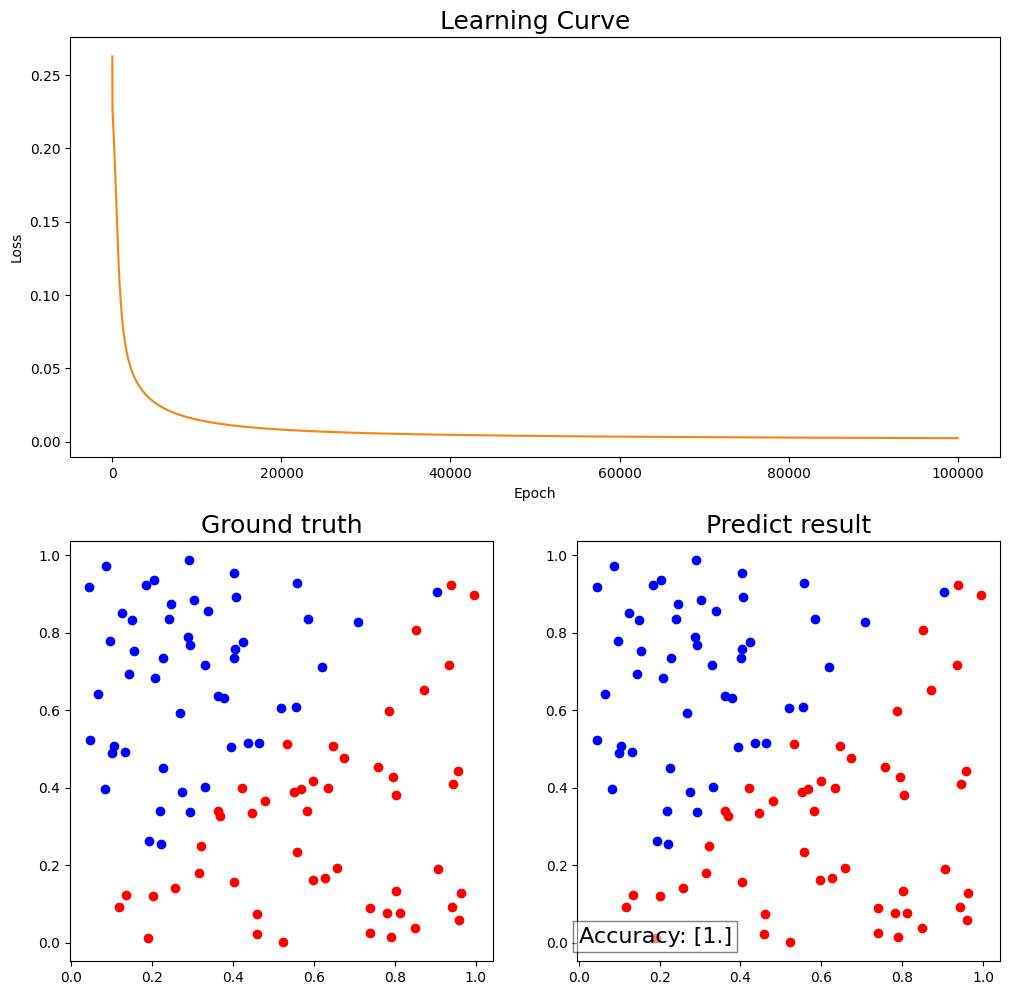

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.29946435457863946
epoch 10000 loss : 0.01979503002117869
epoch 20000 loss : 0.0026897322267163083
epoch 30000 loss : 0.0012163680854239457
epoch 40000 loss : 0.0007556068693309222
epoch 50000 loss : 0.0005391599957320184
epoch 60000 loss : 0.00041549212719210304
epoch 70000 loss : 0.000336190540220543
epoch 80000 loss : 0.0002813161950521223
epoch 90000 loss : 0.00024123864075245013
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.01421017] |
Iter2 |    Ground truth: [1] |     prediction: [0.99721193] |
Iter3 |    Ground truth: [0] |     prediction: [0.01416393] |
Iter4 |    Ground truth: [1] |     prediction: [0.99702673] |
Iter5 |    Ground truth: [0] |     prediction: [0.01410663] |
Iter6 |    Ground truth: [1] |     prediction: [0.99655806] |
Iter7 |    Ground truth: [0] |     prediction: [0.01404075] |
Iter8 |    Ground truth: [1] |     prediction: [0.99485846] |
Iter9 |    Ground truth: [0] |     prediction: [0.01396904] |
Iter10 | 

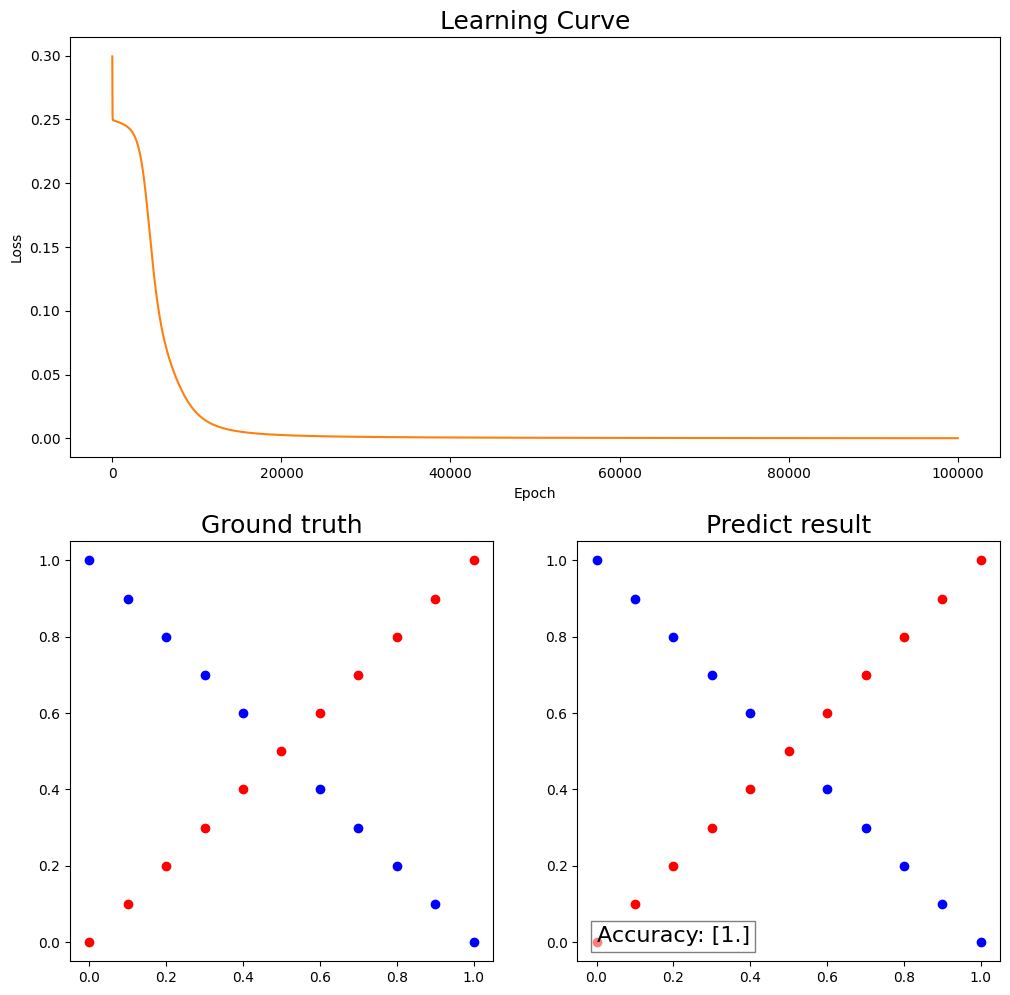

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.23199406368820266
epoch 10000 loss : 0.11372344977035599
epoch 20000 loss : 0.05442736310127628
epoch 30000 loss : 0.03561651451323102
epoch 40000 loss : 0.027073322998269273
epoch 50000 loss : 0.022072776643559323
epoch 60000 loss : 0.01877580713592903
epoch 70000 loss : 0.016432431130853603
epoch 80000 loss : 0.01467030257740384
epoch 90000 loss : 0.013282067474560334
Accuracy : [0.99]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00073187] |
Iter2 |    Ground truth: [0] |     prediction: [0.05194577] |
Iter3 |    Ground truth: [0] |     prediction: [0.00037264] |
Iter4 |    Ground truth: [1] |     prediction: [0.99821876] |
Iter5 |    Ground truth: [1] |     prediction: [0.99929813] |
Iter6 |    Ground truth: [1] |     prediction: [0.98338102] |
Iter7 |    Ground truth: [0] |     prediction: [0.20071697] |
Iter8 |    Ground truth: [1] |     prediction: [0.9783477] |
Iter9 |    Ground truth: [0] |     prediction: [0.02247801] |
Iter10 |    Ground tr

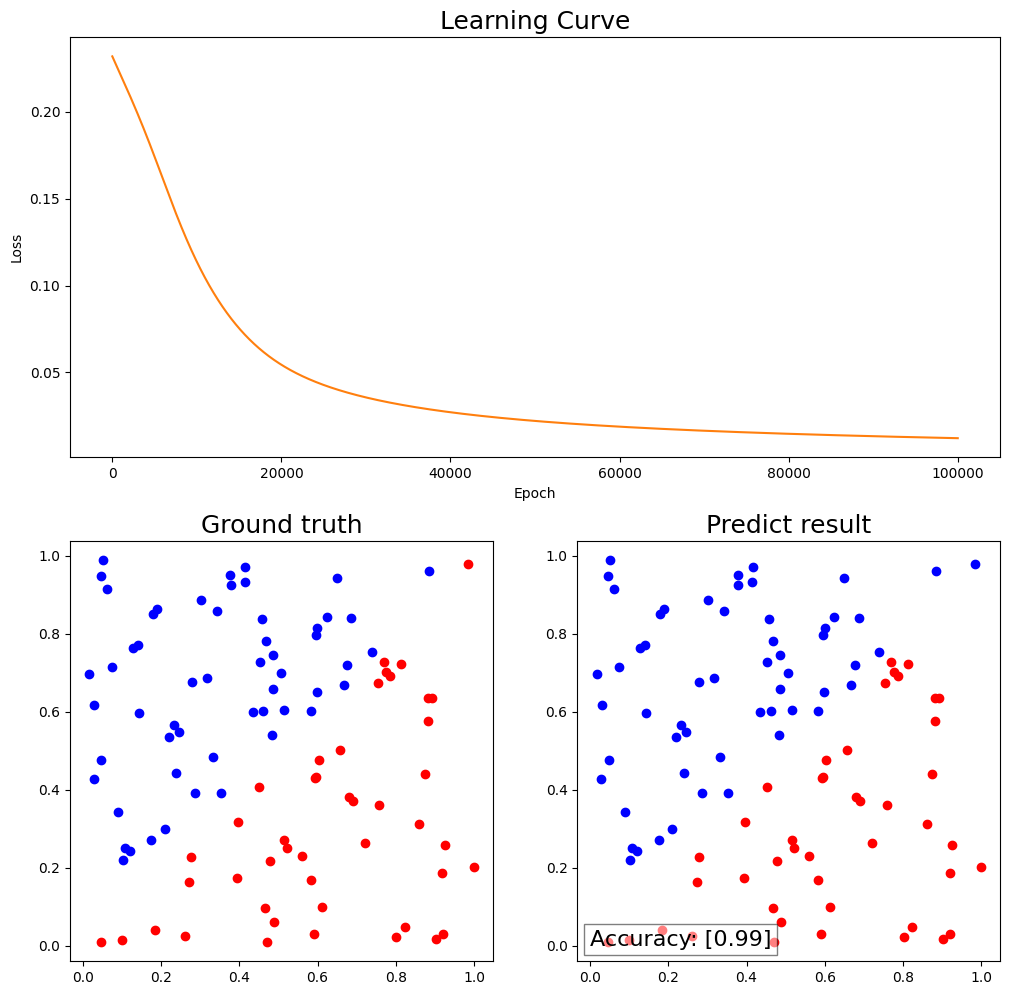

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.01)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2696713576251838
epoch 10000 loss : 0.21941607031585314
epoch 20000 loss : 0.189933651240051
epoch 30000 loss : 0.16563972282692496
epoch 40000 loss : 0.14617277966755352
epoch 50000 loss : 0.12983911522143343
epoch 60000 loss : 0.11588950150303201
epoch 70000 loss : 0.10396773763904232
epoch 80000 loss : 0.09380635187249639
epoch 90000 loss : 0.08515699113803189
Accuracy : [0.99]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.13456236] |
Iter2 |    Ground truth: [1] |     prediction: [0.86648499] |
Iter3 |    Ground truth: [0] |     prediction: [0.08002751] |
Iter4 |    Ground truth: [1] |     prediction: [0.79425925] |
Iter5 |    Ground truth: [0] |     prediction: [0.33205818] |
Iter6 |    Ground truth: [1] |     prediction: [0.4559321] |
Iter7 |    Ground truth: [0] |     prediction: [0.31645431] |
Iter8 |    Ground truth: [0] |     prediction: [0.16639348] |
Iter9 |    Ground truth: [1] |     prediction: [0.72243936] |
Iter10 |    Ground truth: [1

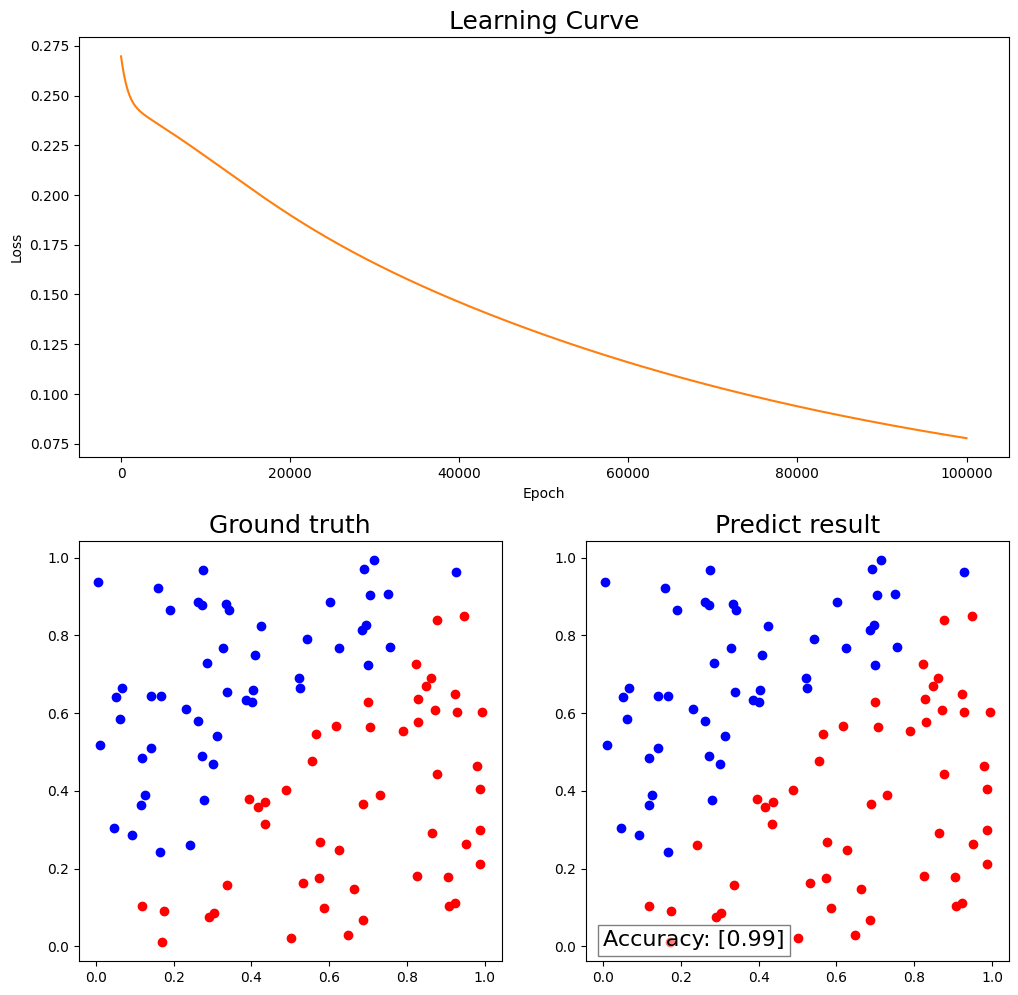

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.001)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.3870015730130058
epoch 10000 loss : 0.2432793845876438
epoch 20000 loss : 0.2348859211271312
epoch 30000 loss : 0.21821184442396993
epoch 40000 loss : 0.1825132385792998
epoch 50000 loss : 0.12768421694604792
epoch 60000 loss : 0.0865698798129201
epoch 70000 loss : 0.06273072826461686
epoch 80000 loss : 0.0471050844112706
epoch 90000 loss : 0.03566059627894005
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.03238628] |
Iter2 |    Ground truth: [1] |     prediction: [0.92819282] |
Iter3 |    Ground truth: [0] |     prediction: [0.06242046] |
Iter4 |    Ground truth: [1] |     prediction: [0.93127961] |
Iter5 |    Ground truth: [0] |     prediction: [0.11372739] |
Iter6 |    Ground truth: [1] |     prediction: [0.93538296] |
Iter7 |    Ground truth: [0] |     prediction: [0.16886817] |
Iter8 |    Ground truth: [1] |     prediction: [0.92691323] |
Iter9 |    Ground truth: [0] |     prediction: [0.20262485] |
Iter10 |    Ground truth: [1] | 

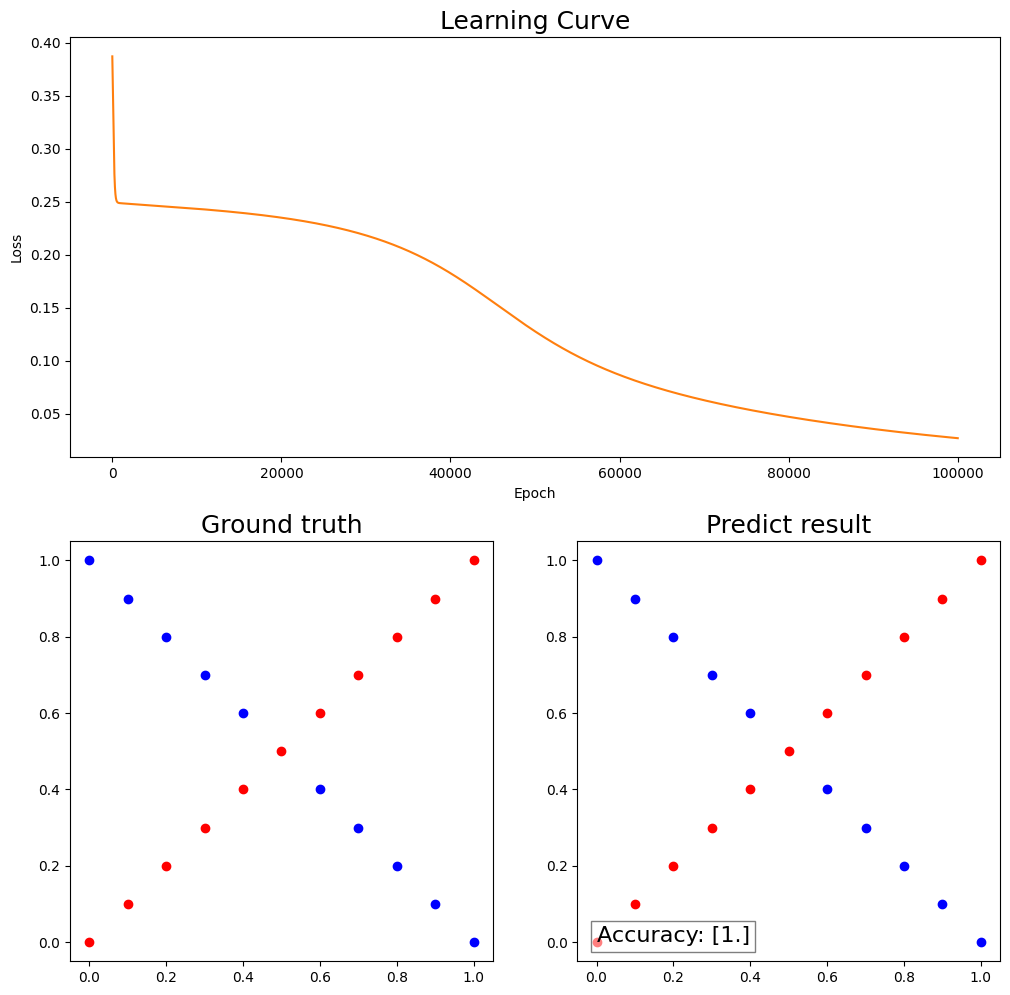

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.01)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.3207076139793694
epoch 10000 loss : 0.25186017093627433
epoch 20000 loss : 0.2508523763486907
epoch 30000 loss : 0.24997330268806428
epoch 40000 loss : 0.2492022481457548
epoch 50000 loss : 0.24851776008237514
epoch 60000 loss : 0.24789834199680794
epoch 70000 loss : 0.2473243008719766
epoch 80000 loss : 0.24677867516510826
epoch 90000 loss : 0.24624738036897664
Accuracy : [0.66666667]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.45487913] |
Iter2 |    Ground truth: [1] |     prediction: [0.51909162] |
Iter3 |    Ground truth: [0] |     prediction: [0.46140173] |
Iter4 |    Ground truth: [1] |     prediction: [0.51095095] |
Iter5 |    Ground truth: [0] |     prediction: [0.46658988] |
Iter6 |    Ground truth: [1] |     prediction: [0.50193034] |
Iter7 |    Ground truth: [0] |     prediction: [0.47046415] |
Iter8 |    Ground truth: [1] |     prediction: [0.49253782] |
Iter9 |    Ground truth: [0] |     prediction: [0.473132] |
Iter10 |    Ground truth

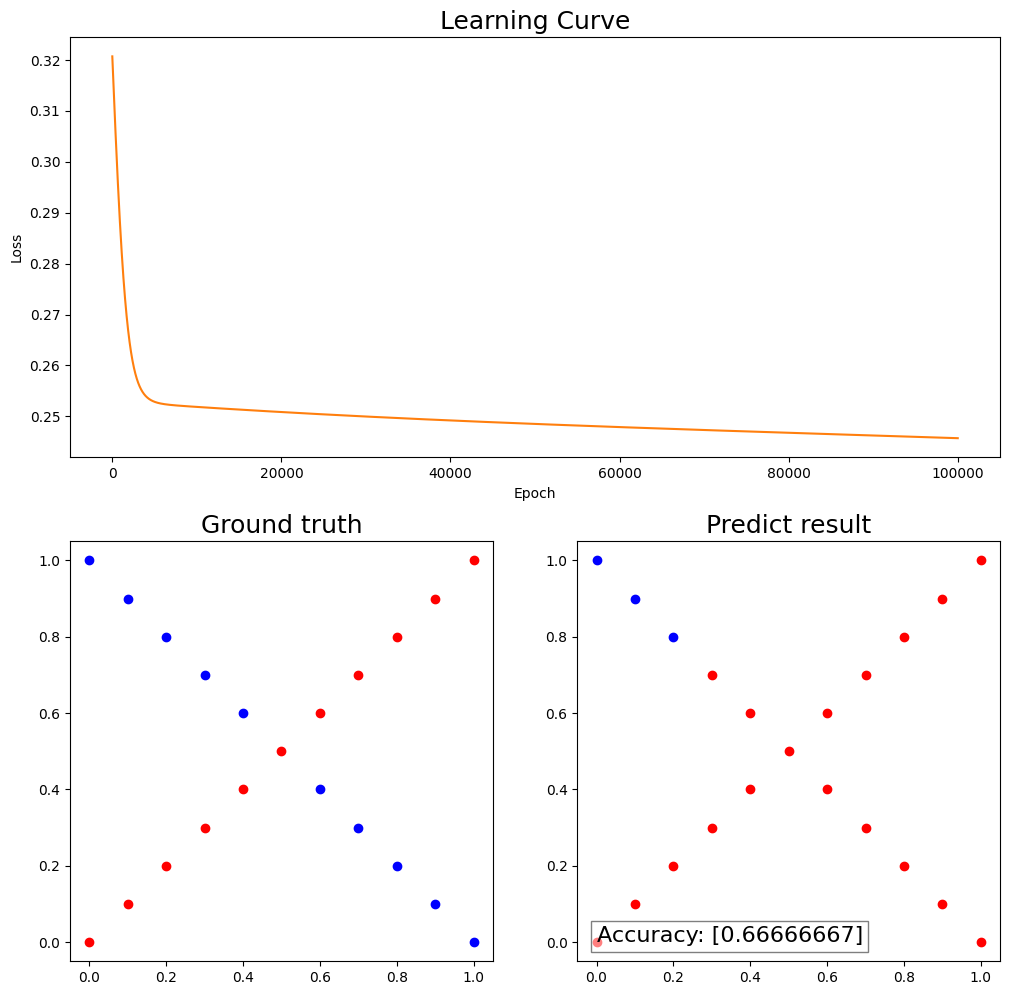

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.001)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2864089088861867
epoch 10000 loss : 0.015067775167412367
epoch 20000 loss : 0.008720953001271596
epoch 30000 loss : 0.006551133733638808
epoch 40000 loss : 0.005373034296956334
epoch 50000 loss : 0.004590756784016182
epoch 60000 loss : 0.0040065304313553814
epoch 70000 loss : 0.003538085785295849
epoch 80000 loss : 0.00314553795038555
epoch 90000 loss : 0.002807267063868416
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00527755] |
Iter2 |    Ground truth: [0] |     prediction: [0.0023325] |
Iter3 |    Ground truth: [0] |     prediction: [0.00283204] |
Iter4 |    Ground truth: [1] |     prediction: [0.99875109] |
Iter5 |    Ground truth: [0] |     prediction: [0.00246692] |
Iter6 |    Ground truth: [1] |     prediction: [0.99874983] |
Iter7 |    Ground truth: [1] |     prediction: [0.99856711] |
Iter8 |    Ground truth: [1] |     prediction: [0.98640083] |
Iter9 |    Ground truth: [1] |     prediction: [0.99874686] |
Iter10 |    Ground 

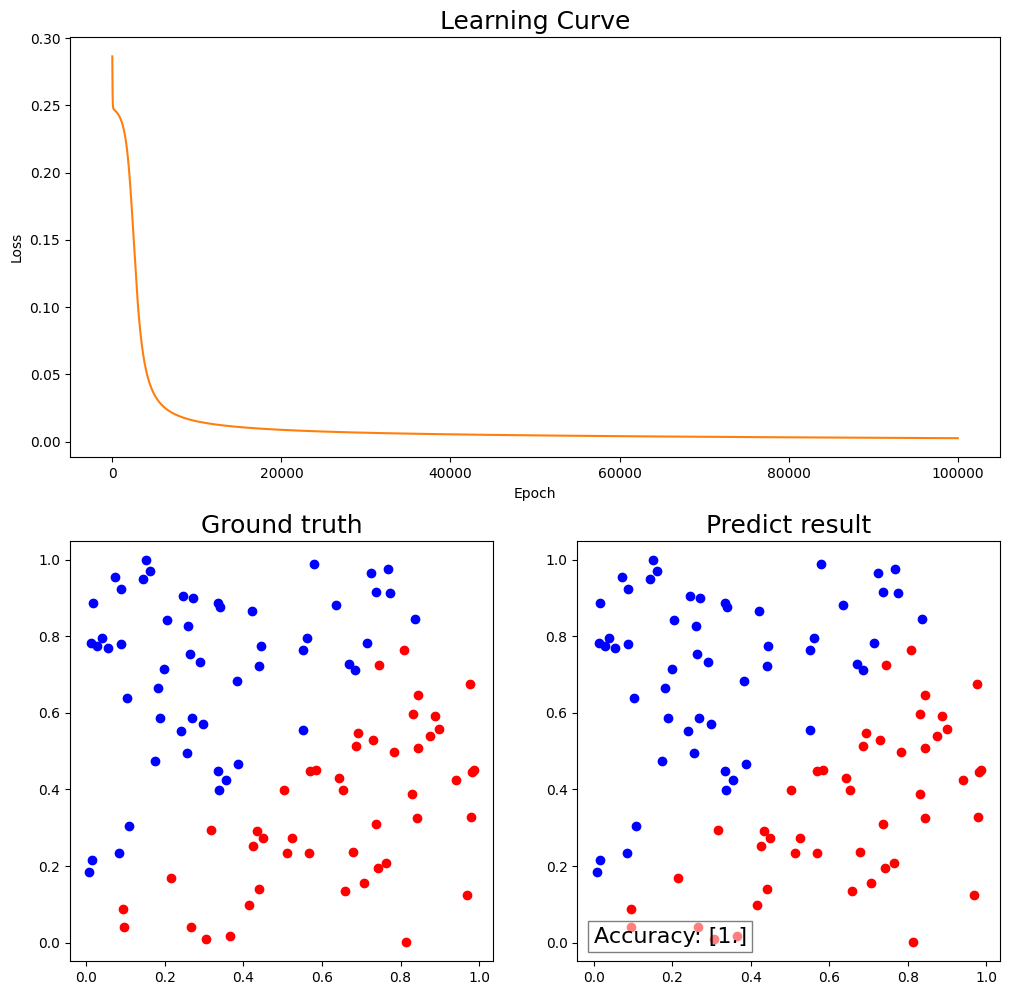

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 2, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.549975088417764
epoch 10000 loss : 0.011081113436538623
epoch 20000 loss : 0.007278177253596791
epoch 30000 loss : 0.0062127027497198015
epoch 40000 loss : 0.0056880080924416624
epoch 50000 loss : 0.005346467384736727
epoch 60000 loss : 0.005082232999593143
epoch 70000 loss : 0.0048552702468001
epoch 80000 loss : 0.00464511095458997
epoch 90000 loss : 0.004436911504593844
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [3.41852075e-09] |
Iter2 |    Ground truth: [1] |     prediction: [1.] |
Iter3 |    Ground truth: [1] |     prediction: [0.99508742] |
Iter4 |    Ground truth: [1] |     prediction: [0.9965407] |
Iter5 |    Ground truth: [1] |     prediction: [0.52209698] |
Iter6 |    Ground truth: [0] |     prediction: [1.51796833e-10] |
Iter7 |    Ground truth: [1] |     prediction: [1.] |
Iter8 |    Ground truth: [0] |     prediction: [4.84334784e-05] |
Iter9 |    Ground truth: [0] |     prediction: [1.28974986e-08] |
Iter10 |    Ground tr

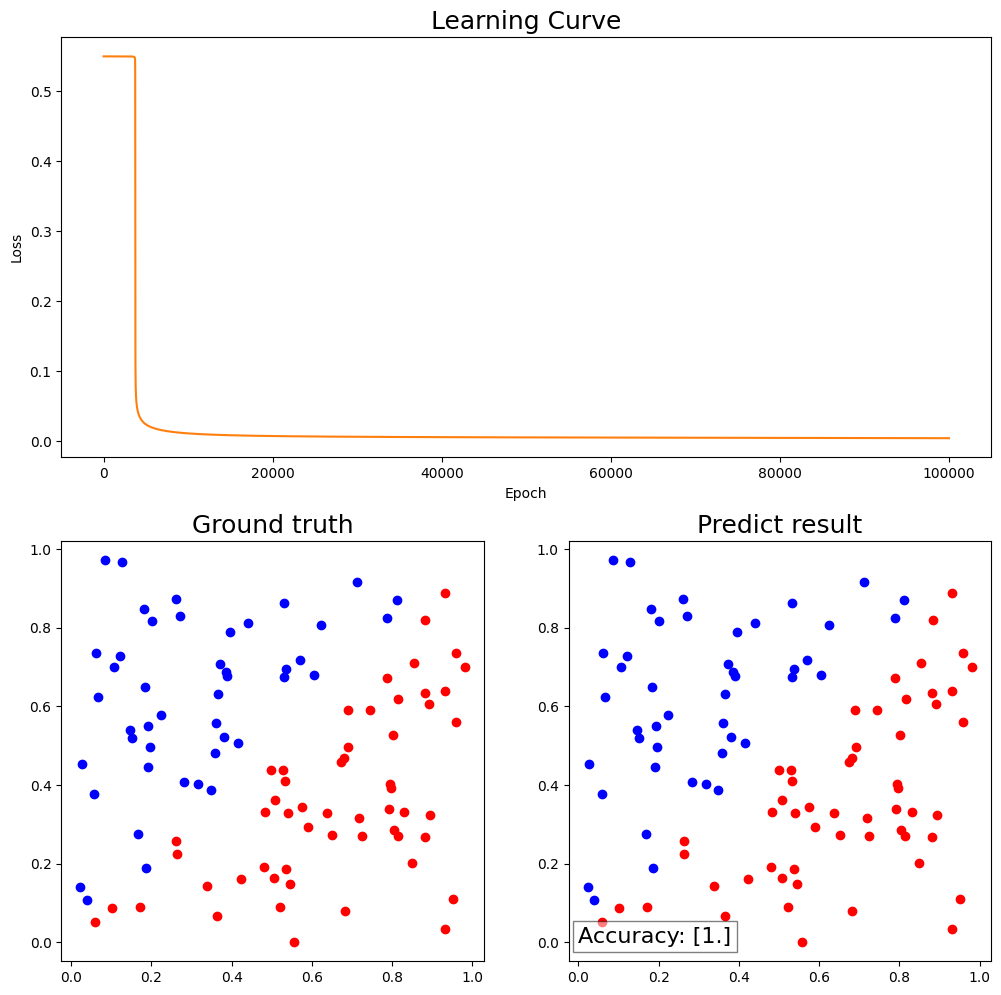

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 100, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2933211996872645
epoch 10000 loss : 0.2494034778996792
epoch 20000 loss : 0.24934843801657264
epoch 30000 loss : 0.24924161337081732
epoch 40000 loss : 0.2488327831972961
epoch 50000 loss : 0.2445371072494004
epoch 60000 loss : 0.20051120769535674
epoch 70000 loss : 0.09549328909604317
epoch 80000 loss : 0.04931000118683433
epoch 90000 loss : 0.04454577470063395
Accuracy : [0.95238095]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00849976] |
Iter2 |    Ground truth: [1] |     prediction: [0.8988358] |
Iter3 |    Ground truth: [0] |     prediction: [0.00851901] |
Iter4 |    Ground truth: [1] |     prediction: [0.8988358] |
Iter5 |    Ground truth: [0] |     prediction: [0.00866845] |
Iter6 |    Ground truth: [1] |     prediction: [0.8988358] |
Iter7 |    Ground truth: [0] |     prediction: [0.01006297] |
Iter8 |    Ground truth: [1] |     prediction: [0.8988358] |
Iter9 |    Ground truth: [0] |     prediction: [0.07838645] |
Iter10 |    Ground truth: 

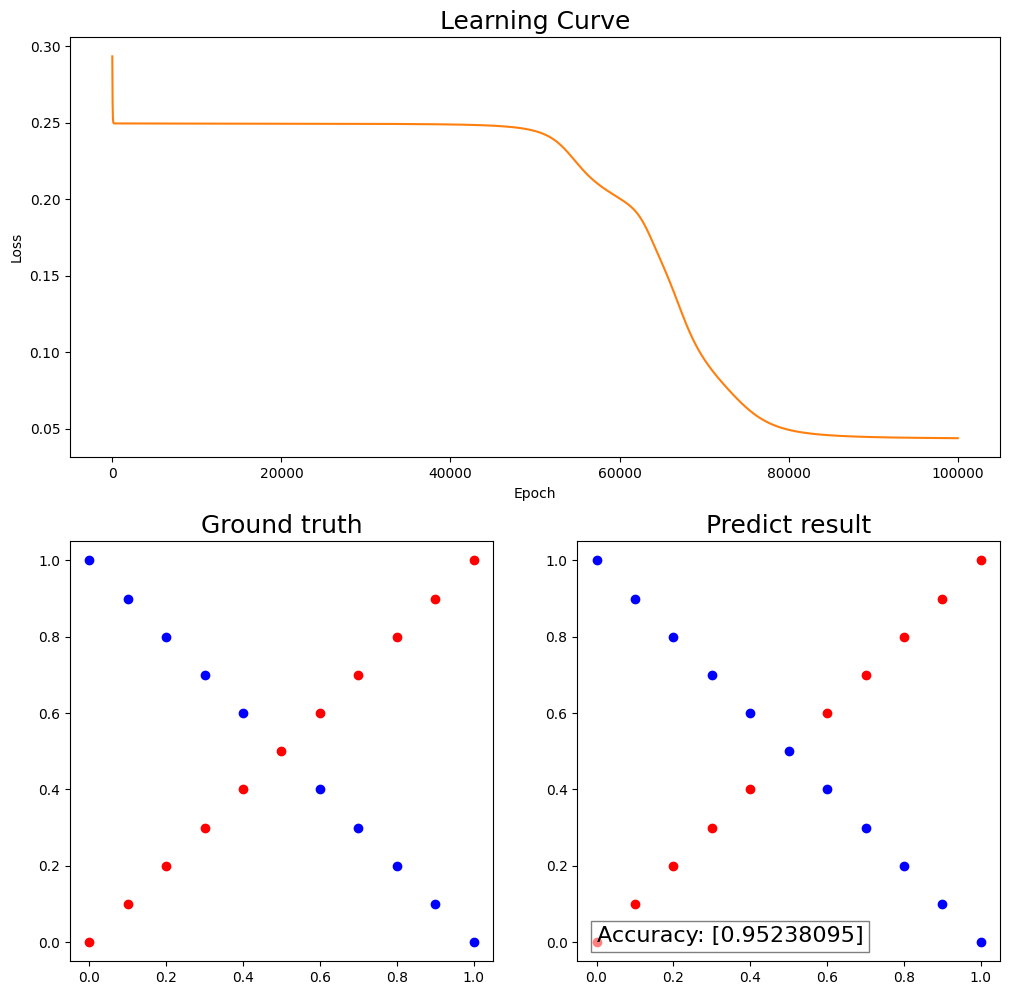

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 2, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.5237689956457255
epoch 10000 loss : 0.01597272218045122
epoch 20000 loss : 0.002597847443393312
epoch 30000 loss : 0.0010525379430104665
epoch 40000 loss : 0.0006088574332931502
epoch 50000 loss : 0.00041408493903096394
epoch 60000 loss : 0.0003081829719149192
epoch 70000 loss : 0.00024278935447072107
epoch 80000 loss : 0.00019887119519877762
epoch 90000 loss : 0.00016756888459497466
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.0003073] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999305] |
Iter3 |    Ground truth: [0] |     prediction: [0.00051736] |
Iter4 |    Ground truth: [1] |     prediction: [0.99998905] |
Iter5 |    Ground truth: [0] |     prediction: [0.00123058] |
Iter6 |    Ground truth: [1] |     prediction: [0.99997026] |
Iter7 |    Ground truth: [0] |     prediction: [0.00441757] |
Iter8 |    Ground truth: [1] |     prediction: [0.99976154] |
Iter9 |    Ground truth: [0] |     prediction: [0.01762113] |
Iter10 | 

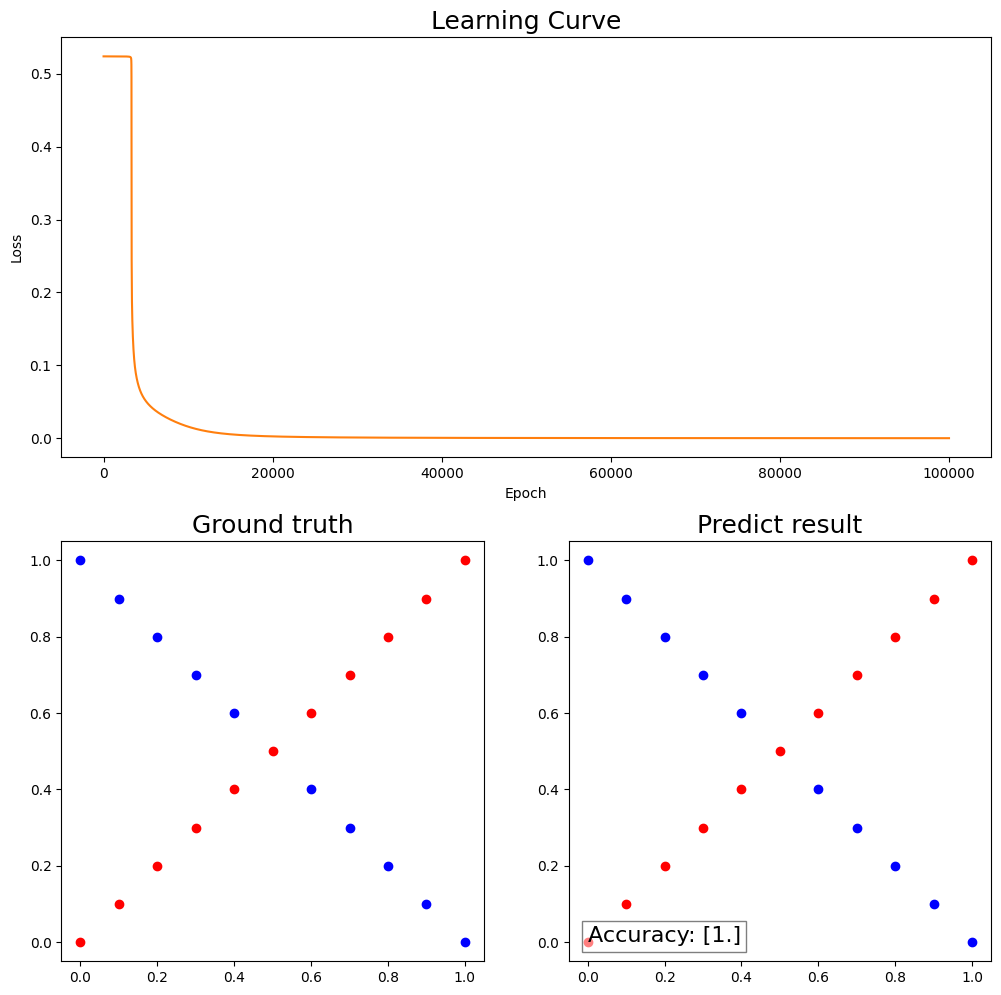

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 100, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 101.04983856740908
epoch 10000 loss : 2.642131803886845
epoch 20000 loss : 1.4359047275164973
epoch 30000 loss : 0.8786464276709524
epoch 40000 loss : 0.5931495660589966
epoch 50000 loss : 0.43676337362601886
epoch 60000 loss : 0.34446192752027477
epoch 70000 loss : 0.28550392455243356
epoch 80000 loss : 0.24490192259534443
epoch 90000 loss : 0.21510265896298858
Accuracy : [0.78]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.82815829] |
Iter2 |    Ground truth: [0] |     prediction: [-0.21482832] |
Iter3 |    Ground truth: [0] |     prediction: [0.2095407] |
Iter4 |    Ground truth: [0] |     prediction: [-0.22655974] |
Iter5 |    Ground truth: [0] |     prediction: [0.085783] |
Iter6 |    Ground truth: [0] |     prediction: [-0.39329857] |
Iter7 |    Ground truth: [1] |     prediction: [0.72603392] |
Iter8 |    Ground truth: [0] |     prediction: [0.6369615] |
Iter9 |    Ground truth: [1] |     prediction: [1.23597966] |
Iter10 |    Ground truth: [0] |

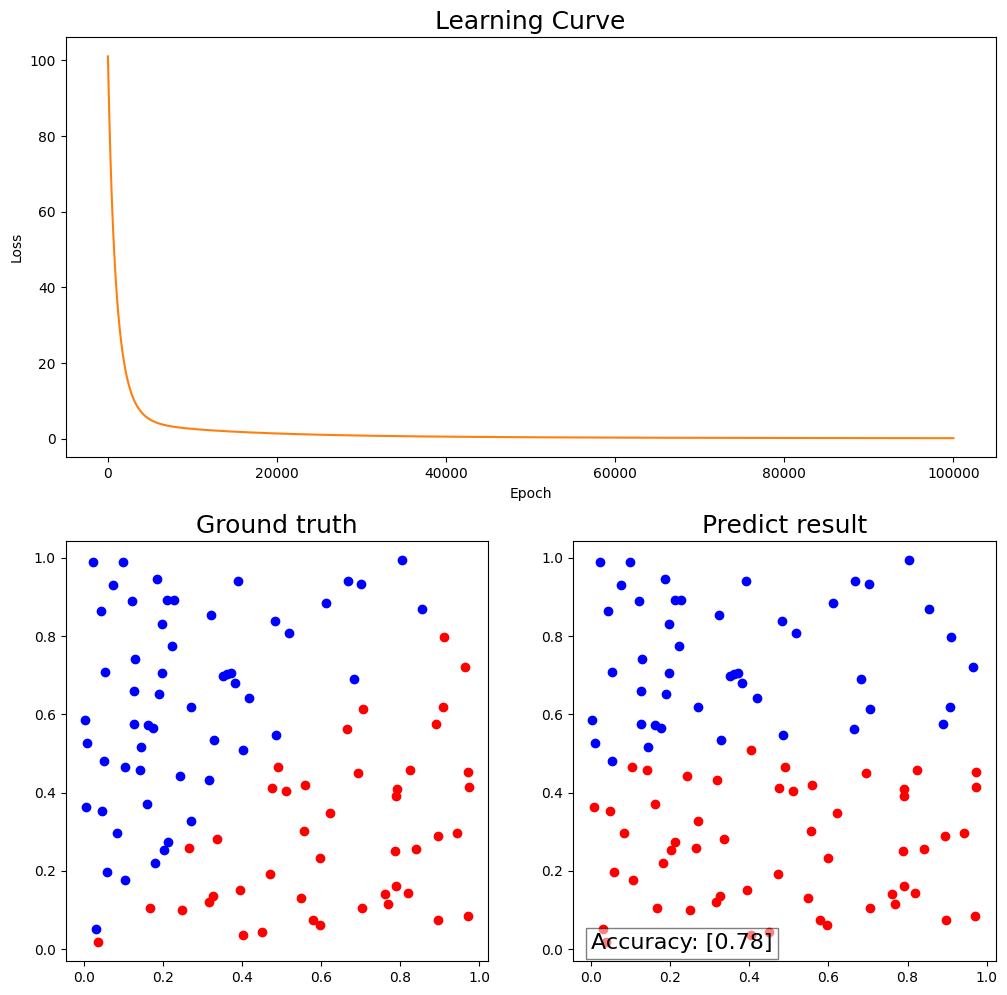

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "None", lr = 1e-6)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 2.018397230721173
epoch 10000 loss : 1.2709330948630804
epoch 20000 loss : 0.9542167339012144
epoch 30000 loss : 0.7405733154029002
epoch 40000 loss : 0.5942890519830533
epoch 50000 loss : 0.49299266324775504
epoch 60000 loss : 0.42223926599484585
epoch 70000 loss : 0.37248529908326494
epoch 80000 loss : 0.33731175910165134
epoch 90000 loss : 0.31234032081956714
Accuracy : [0.57142857]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.37404246] |
Iter2 |    Ground truth: [1] |     prediction: [0.01419701] |
Iter3 |    Ground truth: [0] |     prediction: [0.39288479] |
Iter4 |    Ground truth: [1] |     prediction: [0.10500843] |
Iter5 |    Ground truth: [0] |     prediction: [0.41172712] |
Iter6 |    Ground truth: [1] |     prediction: [0.19581985] |
Iter7 |    Ground truth: [0] |     prediction: [0.43056945] |
Iter8 |    Ground truth: [1] |     prediction: [0.28663127] |
Iter9 |    Ground truth: [0] |     prediction: [0.44941178] |
Iter10 |    Ground truth

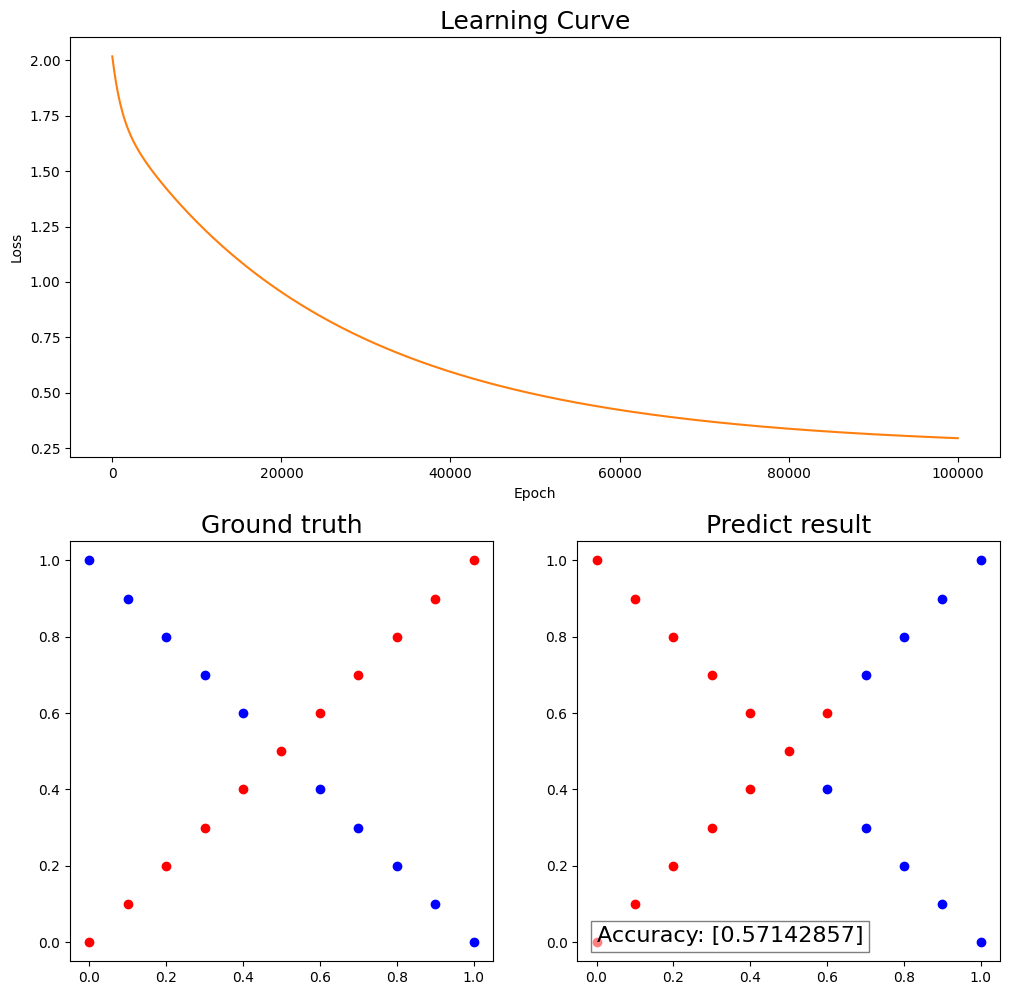

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "None", lr = 1e-6)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.4115206503761339
epoch 10000 loss : 0.0015774638962113184
epoch 20000 loss : 0.0006233997040195172
epoch 30000 loss : 0.0003436860874512497
epoch 40000 loss : 0.0002232093857818139
epoch 50000 loss : 0.00015953966470529695
epoch 60000 loss : 0.00012137603691310292
epoch 70000 loss : 9.646530674411586e-05
epoch 80000 loss : 7.917366203732899e-05
epoch 90000 loss : 6.660025248616362e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [4.76712221e-08] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999997] |
Iter3 |    Ground truth: [1] |     prediction: [0.99999997] |
Iter4 |    Ground truth: [1] |     prediction: [0.99998759] |
Iter5 |    Ground truth: [1] |     prediction: [0.99999999] |
Iter6 |    Ground truth: [0] |     prediction: [2.7162385e-09] |
Iter7 |    Ground truth: [0] |     prediction: [3.73436807e-09] |
Iter8 |    Ground truth: [0] |     prediction: [5.93562034e-09] |
Iter9 |    Ground truth: [1] |     prediction: [0.9998

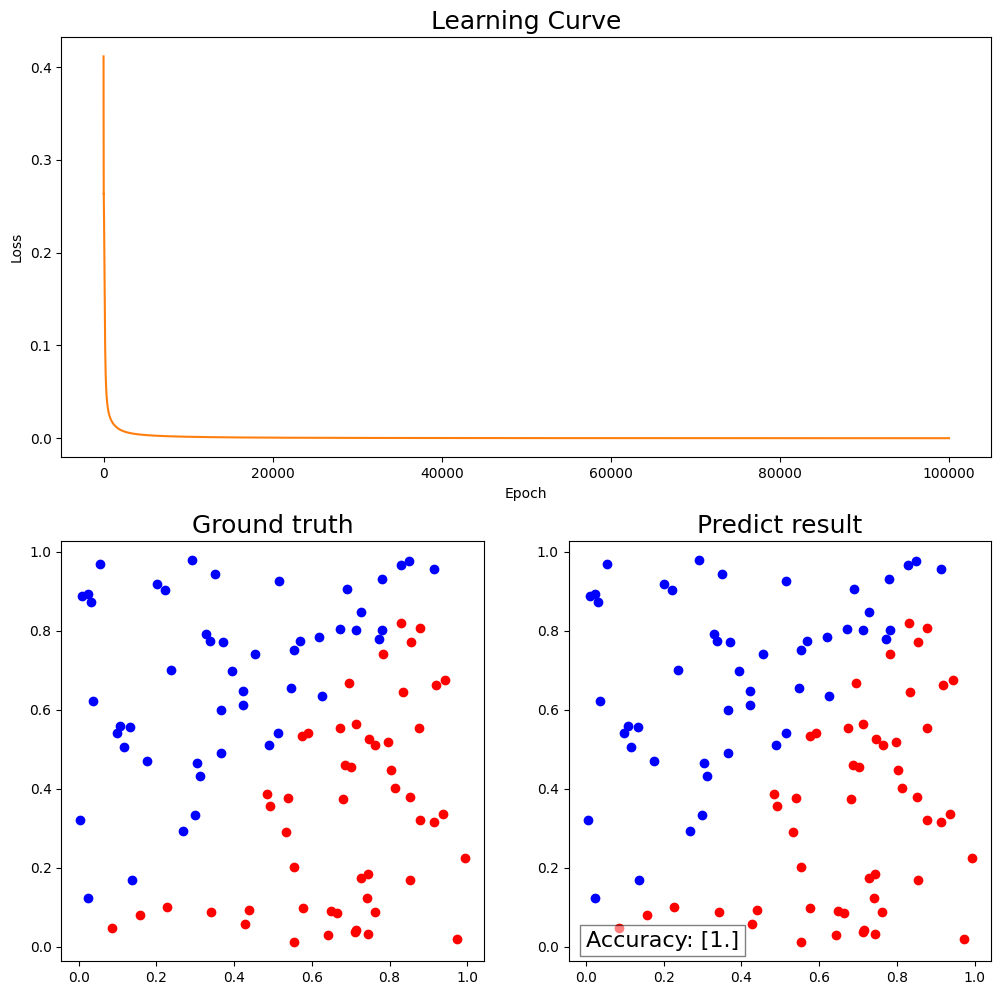

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "momentum", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.42679904265598173
epoch 10000 loss : 0.0030773623109463404
epoch 20000 loss : 0.0007540701062600039
epoch 30000 loss : 0.00034331032925758413
epoch 40000 loss : 0.0002060251791980798
epoch 50000 loss : 0.00014207531337379135
epoch 60000 loss : 0.00010630967732519574
epoch 70000 loss : 8.389148472781309e-05
epoch 80000 loss : 6.870823060859013e-05
epoch 90000 loss : 5.783418163762387e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [1.] |
Iter2 |    Ground truth: [1] |     prediction: [1.] |
Iter3 |    Ground truth: [0] |     prediction: [4.68938491e-11] |
Iter4 |    Ground truth: [1] |     prediction: [1.] |
Iter5 |    Ground truth: [0] |     prediction: [4.14751057e-13] |
Iter6 |    Ground truth: [1] |     prediction: [1.] |
Iter7 |    Ground truth: [0] |     prediction: [4.1363466e-13] |
Iter8 |    Ground truth: [0] |     prediction: [4.13895272e-13] |
Iter9 |    Ground truth: [1] |     prediction: [1.] |
Iter10 |    Ground truth: [1] 

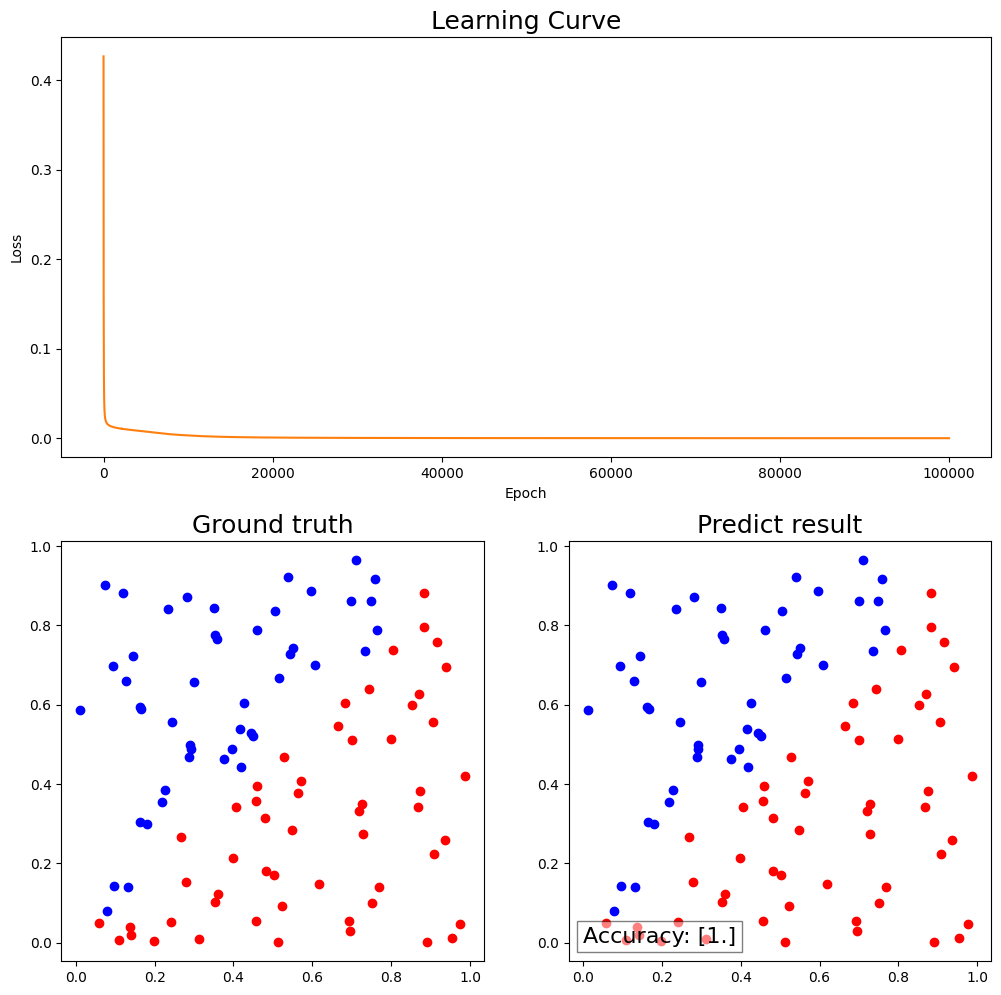

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "AdaGrad", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.34001730527929297
epoch 10000 loss : 0.0003311903413712167
epoch 20000 loss : 0.00011571464903880923
epoch 30000 loss : 6.772300094325198e-05
epoch 40000 loss : 4.7305667098055e-05
epoch 50000 loss : 3.613792064650817e-05
epoch 60000 loss : 2.9138011494327105e-05
epoch 70000 loss : 2.4357024316458407e-05
epoch 80000 loss : 2.0892455923386226e-05
epoch 90000 loss : 1.827075092538794e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00010712] |
Iter2 |    Ground truth: [1] |     prediction: [0.99992408] |
Iter3 |    Ground truth: [0] |     prediction: [0.00014485] |
Iter4 |    Ground truth: [1] |     prediction: [0.99991881] |
Iter5 |    Ground truth: [0] |     prediction: [0.00025588] |
Iter6 |    Ground truth: [1] |     prediction: [0.99990708] |
Iter7 |    Ground truth: [0] |     prediction: [0.00083076] |
Iter8 |    Ground truth: [1] |     prediction: [0.99982609] |
Iter9 |    Ground truth: [0] |     prediction: [0.00705971] |
Iter10

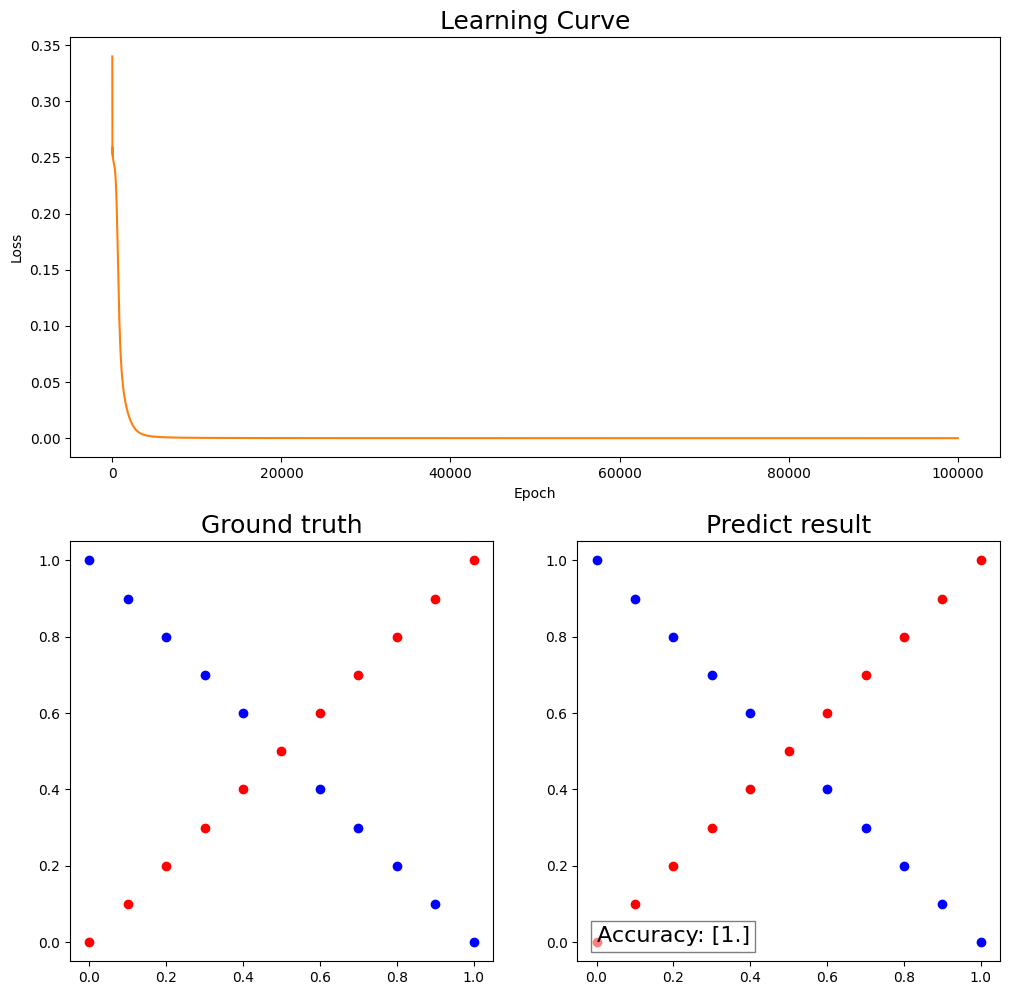

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "momentum", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2546548940476113
epoch 10000 loss : 0.00010842932060362552
epoch 20000 loss : 4.699881919909772e-05
epoch 30000 loss : 2.9468893723447197e-05
epoch 40000 loss : 2.1303612148852434e-05
epoch 50000 loss : 1.661328142362187e-05
epoch 60000 loss : 1.3580416762730777e-05
epoch 70000 loss : 1.1463499118128951e-05
epoch 80000 loss : 9.904635471614253e-06
epoch 90000 loss : 8.710314874081777e-06
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [2.51534498e-05] |
Iter2 |    Ground truth: [1] |     prediction: [0.99845379] |
Iter3 |    Ground truth: [0] |     prediction: [5.71141935e-05] |
Iter4 |    Ground truth: [1] |     prediction: [0.99908962] |
Iter5 |    Ground truth: [0] |     prediction: [0.00021574] |
Iter6 |    Ground truth: [1] |     prediction: [0.99936883] |
Iter7 |    Ground truth: [0] |     prediction: [0.00116039] |
Iter8 |    Ground truth: [1] |     prediction: [0.99924731] |
Iter9 |    Ground truth: [0] |     prediction: [0.00489204

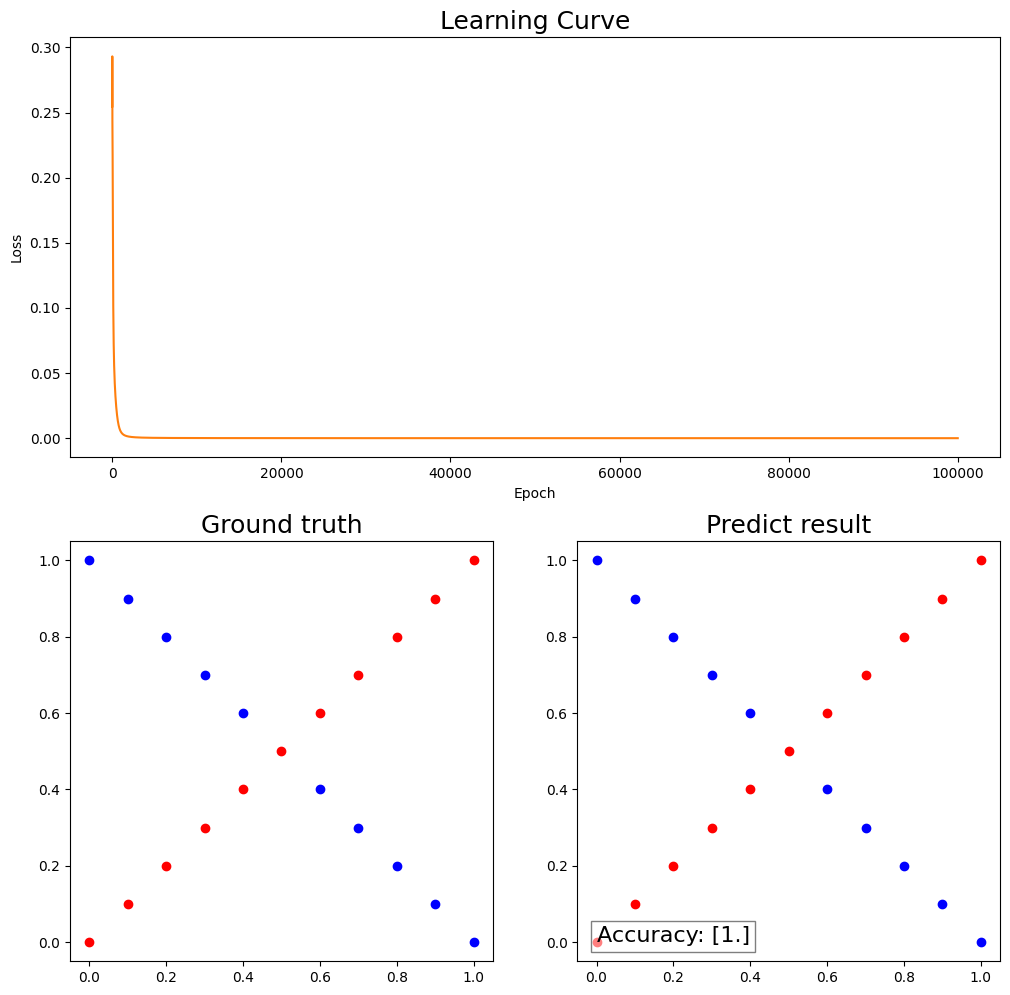

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "AdaGrad", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.5215947790942905
epoch 10000 loss : 0.0012167145174154243
epoch 20000 loss : 0.0004995395553766973
epoch 30000 loss : 0.00029121130775140535
epoch 40000 loss : 0.00019932992861068386
epoch 50000 loss : 0.0001492297969403162
epoch 60000 loss : 0.00011821879649696232
epoch 70000 loss : 9.717910968639732e-05
epoch 80000 loss : 8.225859350487903e-05
epoch 90000 loss : 7.105831127263815e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [1.] |
Iter2 |    Ground truth: [0] |     prediction: [1.09597622e-25] |
Iter3 |    Ground truth: [0] |     prediction: [1.35021498e-20] |
Iter4 |    Ground truth: [0] |     prediction: [3.7785971e-15] |
Iter5 |    Ground truth: [0] |     prediction: [0.00305569] |
Iter6 |    Ground truth: [1] |     prediction: [0.99999998] |
Iter7 |    Ground truth: [1] |     prediction: [1.] |
Iter8 |    Ground truth: [1] |     prediction: [0.9407749] |
Iter9 |    Ground truth: [1] |     prediction: [1.] |
Iter10 |    Ground t

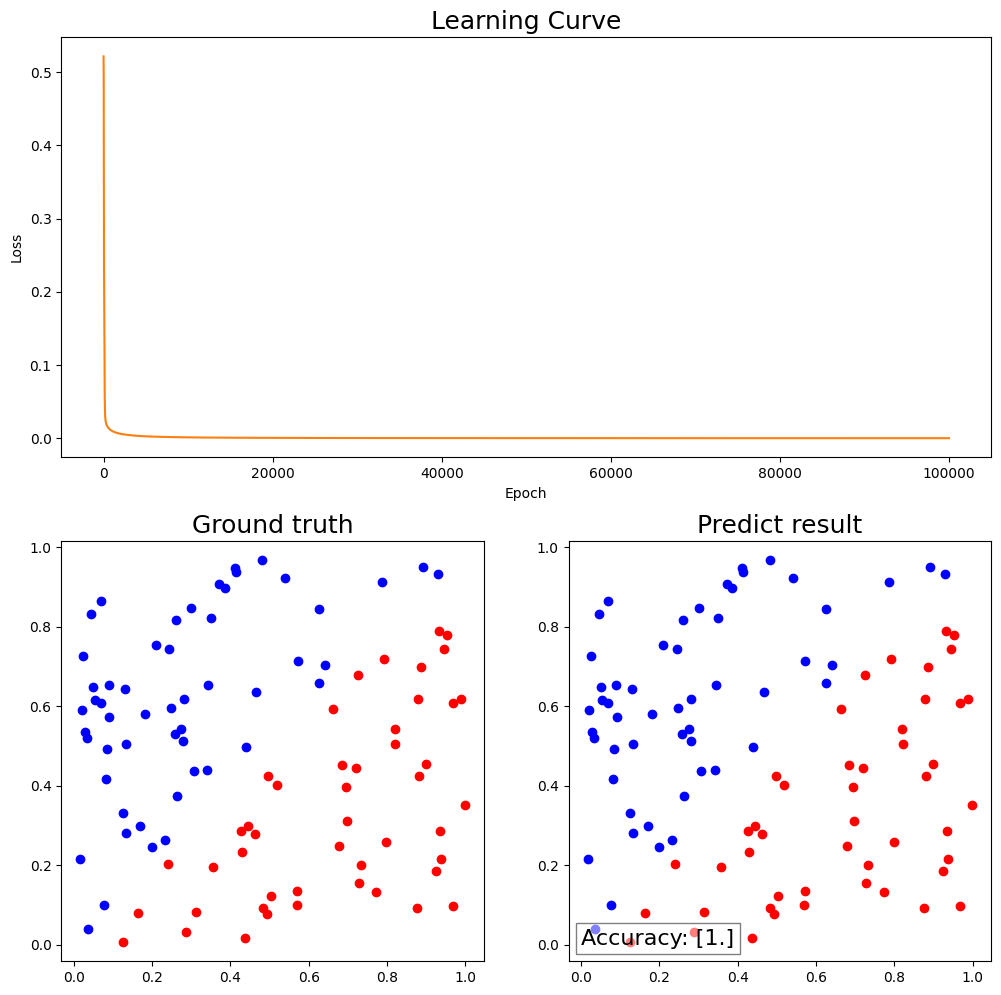

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "ReLU", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.32840312531960675
epoch 10000 loss : 0.002972824006673994
epoch 20000 loss : 0.0011053311736727936
epoch 30000 loss : 0.0005710096289352021
epoch 40000 loss : 0.0003534987154920981
epoch 50000 loss : 0.0002445607254511949
epoch 60000 loss : 0.0001819576445095688
epoch 70000 loss : 0.00014237497977877473
epoch 80000 loss : 0.00011555343921246235
epoch 90000 loss : 9.640792883825353e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.99999998] |
Iter2 |    Ground truth: [0] |     prediction: [1.77201119e-08] |
Iter3 |    Ground truth: [1] |     prediction: [0.99999998] |
Iter4 |    Ground truth: [0] |     prediction: [1.5945274e-08] |
Iter5 |    Ground truth: [0] |     prediction: [1.09331878e-07] |
Iter6 |    Ground truth: [1] |     prediction: [0.99999999] |
Iter7 |    Ground truth: [1] |     prediction: [0.99999706] |
Iter8 |    Ground truth: [1] |     prediction: [0.99999998] |
Iter9 |    Ground truth: [1] |     prediction: [0.99999999

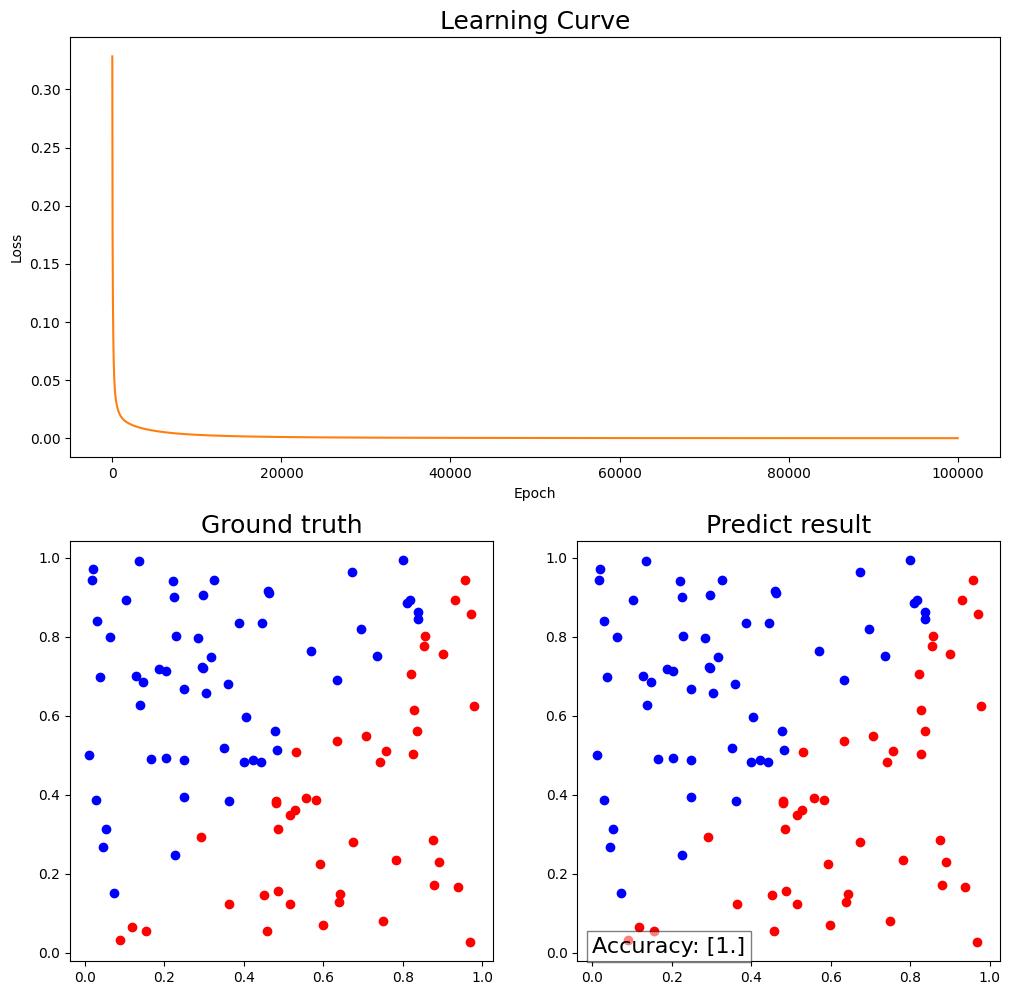

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "tanh", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.263074492647186
epoch 10000 loss : 0.0005781763506526125
epoch 20000 loss : 0.00024763369887614893
epoch 30000 loss : 0.00015411653121820995
epoch 40000 loss : 0.00011088703005730582
epoch 50000 loss : 8.646527340849934e-05
epoch 60000 loss : 7.068897925601072e-05
epoch 70000 loss : 5.967611798218532e-05
epoch 80000 loss : 5.156797463981316e-05
epoch 90000 loss : 4.5357756698514666e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.01878237] |
Iter2 |    Ground truth: [1] |     prediction: [0.9999988] |
Iter3 |    Ground truth: [0] |     prediction: [0.01257824] |
Iter4 |    Ground truth: [1] |     prediction: [0.99998765] |
Iter5 |    Ground truth: [0] |     prediction: [0.00909692] |
Iter6 |    Ground truth: [1] |     prediction: [0.99987314] |
Iter7 |    Ground truth: [0] |     prediction: [0.00657273] |
Iter8 |    Ground truth: [1] |     prediction: [0.99869804] |
Iter9 |    Ground truth: [0] |     prediction: [0.0047456] |
Iter10 |

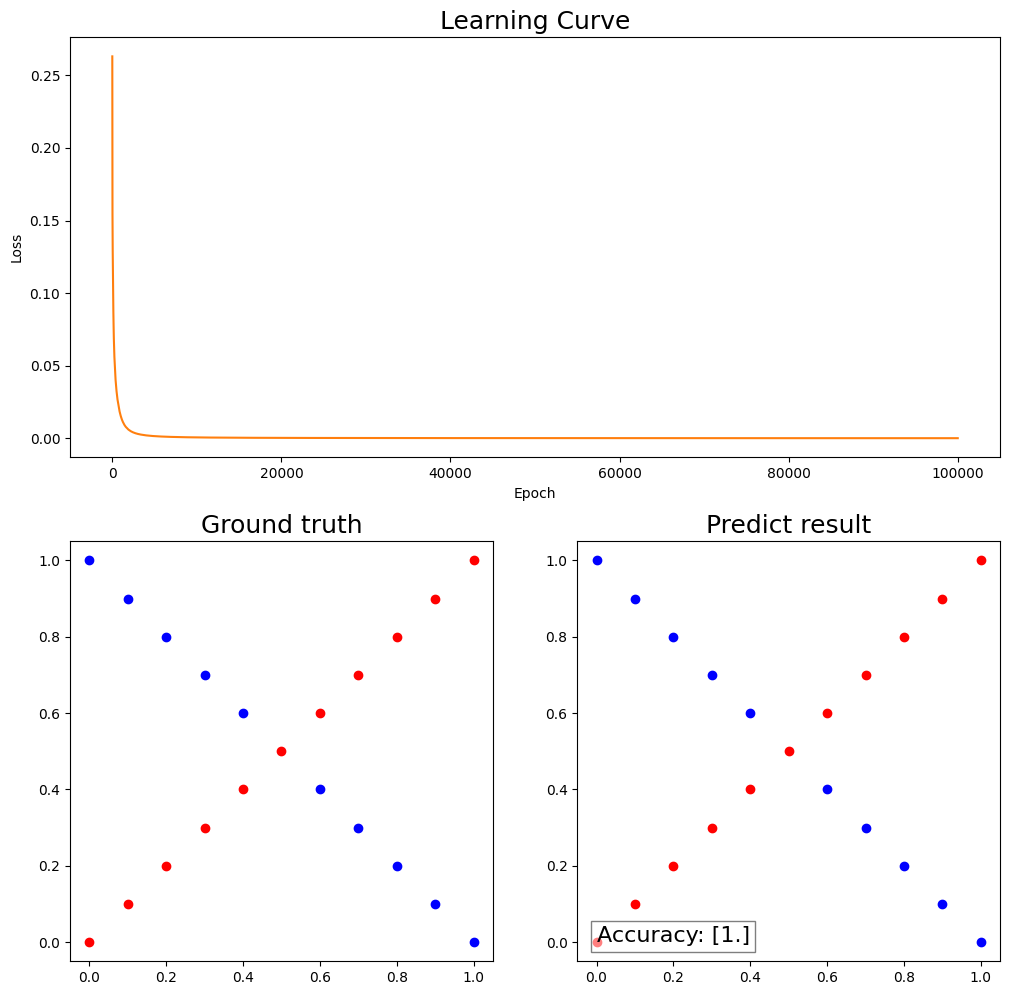

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "ReLU", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.25955702138598585
epoch 10000 loss : 0.00044740577874980293
epoch 20000 loss : 0.00018744854073089626
epoch 30000 loss : 0.00011528518930921138
epoch 40000 loss : 8.224479257546218e-05
epoch 50000 loss : 6.349856225812491e-05
epoch 60000 loss : 5.149269982694512e-05
epoch 70000 loss : 4.317809418901095e-05
epoch 80000 loss : 3.709566169403354e-05
epoch 90000 loss : 3.246210789131337e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00011433] |
Iter2 |    Ground truth: [1] |     prediction: [0.99920717] |
Iter3 |    Ground truth: [0] |     prediction: [0.00036426] |
Iter4 |    Ground truth: [1] |     prediction: [0.99929391] |
Iter5 |    Ground truth: [0] |     prediction: [0.00139647] |
Iter6 |    Ground truth: [1] |     prediction: [0.99931096] |
Iter7 |    Ground truth: [0] |     prediction: [0.00435684] |
Iter8 |    Ground truth: [1] |     prediction: [0.99895409] |
Iter9 |    Ground truth: [0] |     prediction: [0.00843626] |
Iter1

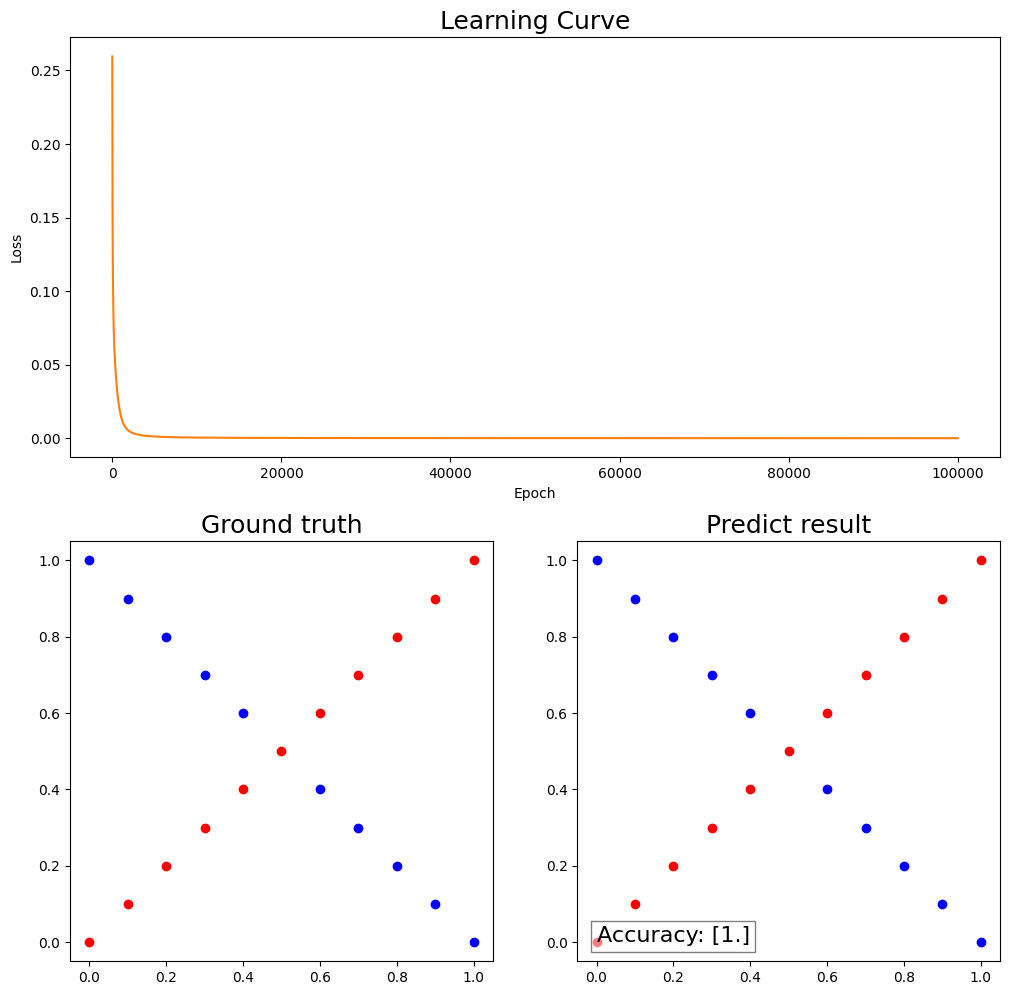

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "tanh", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_linear(n=50, img_size=5):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = np.zeros((n, img_size, img_size))  # 創建適合 CNN 的 2D 平面
    labels = []

    for idx, pt in enumerate(pts):
        inputs[idx, int(pt[0] * (img_size - 1)), int(pt[1] * (img_size - 1))] = 1
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)

    # 增加 channel 維度 (batch_size, channels, height, width)
    inputs = np.expand_dims(inputs, axis=1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy(img_size=5):
    inputs = np.zeros((img_size, img_size))  # 建立一個 5x5 平面
    labels = []

    for i in range(img_size):
        for j in range(img_size):
            if (i == j):
                labels.append(0)  # 對角線為 0
            else:
                labels.append(1)  # 其他點為 1
            inputs[i, j] = labels[-1]

    # 轉換為 CNN 需要的 4D 格式
    inputs = np.expand_dims(inputs, axis=(0, 1))  # 變成 (1, 1, 5, 5)
    labels = np.array(labels).reshape(1, img_size * img_size, 1)  # (1, 25, 1)

    return inputs, labels

def reshape_for_cnn(x):
    n = x.shape[0]
    img_size = int(np.sqrt(n))  # 讓數據變成正方形
    x_reshaped = x.reshape(n, 1, img_size, img_size)  # 增加 Channel 維度
    return x_reshaped

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def ReLU(x):
    return np.where(x > 0, x, 0)

def derivative_ReLU(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1-np.multiply(x, x)

def show_result(x, y, pred_y):
    # **確保 x 為 2D (n, 2)**
    x = x.reshape(x.shape[0], -1)

    # **確保 y 和 pred_y 為 1D**
    y = y.flatten()
    pred_y = pred_y.flatten()

    plt.figure(figsize=(10, 5))

    # **Ground Truth**
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth', fontsize=16)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    # **Predicted Result**
    plt.subplot(1, 2, 2)
    plt.title('Predicted Result', fontsize=16)
    plt.text(0, 0, f'Accuracy: {sum(pred_y == y)/y.size:.4f}', fontsize=14,
             bbox=dict(facecolor='white', alpha=0.5))
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

    plt.show()

def MSELoss(y_hat, y, calculate_Grad = True):
    distance = np.sum((y_hat-y)**2)
    if calculate_Grad:
        return distance/y_hat.shape[0], 2*(y_hat - y)/y_hat.shape[0]
    return distance/y_hat.shape[0]

#Fully Connected Layers
class Layer:
    def __init__(self, input_size, output_size, activate = "Sigmoid"):
        self.input_size = input_size
        self.output_size = output_size
        self.activate = activate
        self.v_w = 0
        self.v_b = 0
        self.total_w = 0
        self.total_b = 0
        #initialize weight and bias
        self.w = np.random.randn(input_size, output_size) #shape(2,n)
        self.b = np.random.randn(1, output_size)/100 #shape(1,n)
    def forward(self,x):
        self.x = x
        z = np.dot(x,self.w) +self.b
        if self.activate == "Sigmoid":
            z = sigmoid(z)
        elif self.activate == "ReLU":
            z = ReLU(z)
        elif self.activate == "tanh":
            z = tanh(z)
        else:
            pass
        self.z = z

        return z
    def backward(self, upstream_grad, lr=0.01, optim = "momentum", decay = 0.9):
        if self.activate == "Sigmoid":
            grad = upstream_grad * derivative_sigmoid(self.z)
        elif self.activate == "ReLU":
            grad = upstream_grad * derivative_ReLU(self.z)
        elif self.activate == "tanh":
            grad = upstream_grad * derivative_tanh(self.z)
        else:
            grad = upstream_grad

        if optim == "SGD":
            self.b -= np.sum(grad) * lr
            self.w -= np.dot(self.x.T, grad) *lr
        elif optim == "momentum":
            self.v_w = decay * self.v_w + lr * np.dot(self.x.T, grad)
            self.v_b = decay * self.v_b + lr * np.sum(grad)
            self.b -= self.v_b
            self.w -= self.v_w
        elif optim == "AdaGrad":
            self.total_w += np.dot(self.x.T, grad) ** 2
            self.total_b += np.sum(grad) ** 2
            self.b -= np.sum(grad) * lr / (np.sqrt(self.total_b) + 1e-8)
            self.w -= np.dot(self.x.T, grad) * lr / (np.sqrt(self.total_w) + 1e-8)

        return np.dot(grad,self.w.T)

#Convolutional Layer
class ConvLayer:
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=0, activate="ReLU"):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activate = activate

        # 初始化權重與偏置
        self.w = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.1
        self.b = np.zeros((output_channels, 1))

    def forward(self, x):
        self.x = x
        batch_size, in_channels, height, width = x.shape
        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # 初始化輸出
        self.z = np.zeros((batch_size, self.output_channels, out_height, out_width))

        # 卷積計算
        for b in range(batch_size):
            for oc in range(self.output_channels):
                for ic in range(in_channels):
                    for i in range(out_height):
                        for j in range(out_width):
                            region = x[b, ic, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                            self.z[b, oc, i, j] += np.sum(region * self.w[oc, ic]) + self.b[oc]

        # 激活函數
        if self.activate == "ReLU":
            self.z = np.maximum(0, self.z)
        elif self.activate == "Sigmoid":
            self.z = 1 / (1 + np.exp(-self.z))
        elif self.activate == "tanh":
            self.z = np.tanh(self.z)

        return self.z


#2 FC layers model with conv layer
class Model:
    def __init__(self, input_channels=1, img_size=5, conv_filters=8, kernel_size=3, hidden_size=10, output_size=1,
                 lr=0.01, optim="SGD", activate="ReLU", show_epoch=10000, decay=0.9):
        self.conv = ConvLayer(input_channels, conv_filters, kernel_size, activate=activate)
        self.flatten_size = (img_size - kernel_size + 1) ** 2 * conv_filters  # 計算展平到全連接層後的大小
        self.fc1 = Layer(self.flatten_size, hidden_size, activate)
        self.output = Layer(hidden_size, output_size, "Sigmoid")
        self.lr = lr
        self.loss = []
        self.show_epoch = show_epoch
        self.epoch = 0
        self.optim = optim
        self.decay = decay

    def train(self, x, y, epoch=100000):
        self.epoch += epoch
        for i in range(epoch):
          conv_out = self.conv.forward(x)  # 卷積層
          fc_input = conv_out.reshape(conv_out.shape[0], -1)  # 展平成全連接層輸入
          fc1_out = self.fc1.forward(fc_input)
          output = self.output.forward(fc1_out)

          loss, grad = MSELoss(output, y)
          fc1_grad = self.output.backward(grad, self.lr, self.optim, self.decay)
          self.fc1.backward(fc1_grad, self.lr, self.optim, self.decay)
          self.loss.append(loss)
          self.prediction = output
          if i % self.show_epoch == 0:
            print(f"epoch {i} loss: {loss}")
          plt.subplot(2,1,1)
          plt.title("Learning Curve", fontsize = 18)
          plt.xlabel("Epoch")
          plt.ylabel("Loss")
          plt.plot(loss)

        return output

    def show_result(self,x,y):
        plt.plot(self.loss)
        print(f"Accuracy : {sum((self.prediction > 0.5)== (y==1))/y.size}")
        print("Prediction : ")
        for i in range(y.size):
          print(f"Iter{i+1} |    Ground truth: {y[i]} |     prediction: {self.prediction[i]} |")
        show_result(x,y,self.prediction>0.5)


<ipython-input-6-340946985b1d>:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.z[b, oc, i, j] += np.sum(region * self.w[oc, ic]) + self.b[oc]


epoch 0 loss: 0.19986515816381645
Accuracy : [0.74]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.49247599] |
Iter2 |    Ground truth: [1] |     prediction: [0.5095358] |
Iter3 |    Ground truth: [0] |     prediction: [0.41715408] |
Iter4 |    Ground truth: [1] |     prediction: [0.49496548] |
Iter5 |    Ground truth: [1] |     prediction: [0.56258937] |
Iter6 |    Ground truth: [0] |     prediction: [0.28118198] |
Iter7 |    Ground truth: [0] |     prediction: [0.36602518] |
Iter8 |    Ground truth: [0] |     prediction: [0.41715408] |
Iter9 |    Ground truth: [1] |     prediction: [0.79227114] |
Iter10 |    Ground truth: [0] |     prediction: [0.36602518] |
Iter11 |    Ground truth: [0] |     prediction: [0.48643805] |
Iter12 |    Ground truth: [1] |     prediction: [0.64500097] |
Iter13 |    Ground truth: [0] |     prediction: [0.41715408] |
Iter14 |    Ground truth: [1] |     prediction: [0.49247599] |
Iter15 |    Ground truth: [0] |     prediction: [0.43412889] |

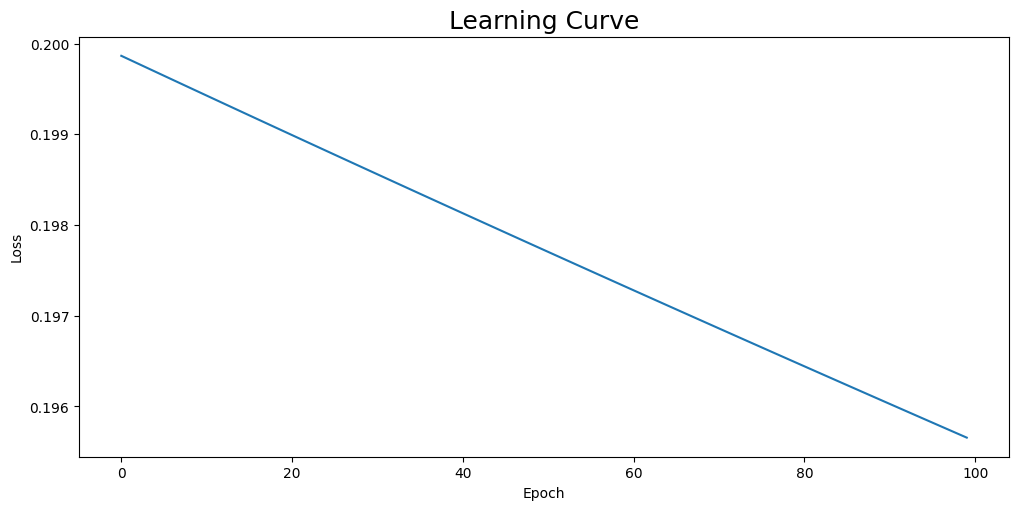

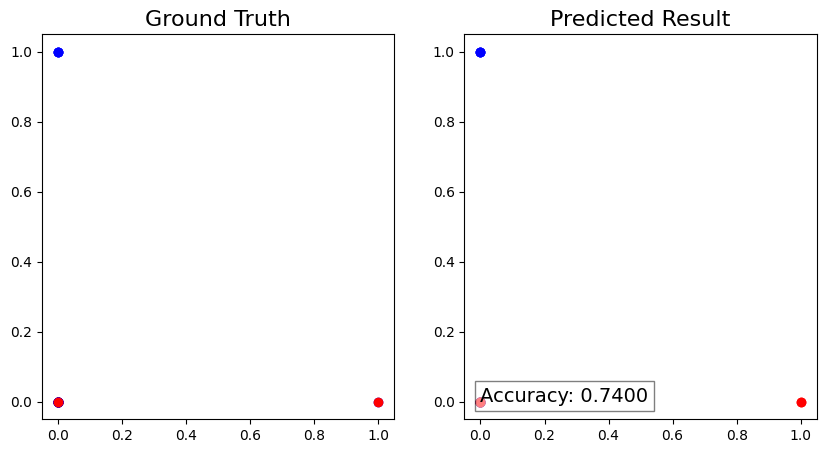

In [ ]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(input_channels=1, img_size=5, conv_filters=8, kernel_size=3, hidden_size=10, optim= "SGD", activate = "ReLU", output_size=1, lr=0.01)
model.train(x,y,100)
model.show_result(x,y)